In [6]:
import json
import pandas as pd
import numpy as np  
import os
import random

from metric import r_precision, dcg_at_k, ndcg_at_k
from utils import generate_playlists, generate_testcases

from numpy import linalg as LA

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
import collections

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
path_to_data = '../../data' #'/content/drive/MyDrive/DO_AN_KHDL/DATA' #'../../data'
path_audio_feats = os.path.join(path_to_data, 'audio_features.tsv')
path_playlists = os.path.join(path_to_data, 'playlists.tsv')
path_tracks = os.path.join(path_to_data, 'tracks.tsv')

In [8]:
pd_audio_feats = pd.read_csv(path_audio_feats, sep = '\t')
pd_tracks = pd.read_csv(path_tracks, sep = '\t')
pd_playlists = pd.read_csv(path_playlists, sep = '\t')
pd_playlists = pd_playlists.fillna('None')

In [9]:
pd_tracks = pd.merge(pd_tracks, pd_audio_feats, left_on = 'track_id', right_on = 'id')
pd_full = pd.merge(pd_tracks, pd_playlists, left_on = 'playlist_id', right_on = 'playlist_id')

pd_tracks = pd_tracks.drop('id', 1)
pd_full = pd_full.drop('playlist_name_y', 1)
pd_full = pd_full.drop('id', 1)

In [10]:
pd_full.shape

(86400, 27)

In [11]:
#Thông tin rỗng là discription, ta có thể chỉ điền vào "None"
pd_full = pd_full.fillna('None')

In [12]:
#Kiểm tra và bỏ giá trị trùng lặp
pd_full = pd_full.drop_duplicates()

In [13]:
pd_full['available_markets'] = pd_full['available_markets'].apply(lambda x : x[1:-1].split(', '))
pd_full['count_available_markets'] = pd_full['available_markets'].apply(lambda x : len(x))

In [14]:
pd_full.shape

(86350, 28)

## baseline_improvement

* **Thuộc tính**: chọn 5 features tốt nhất lấy từ 2 mô hình `LightGBM` và `ExtraTreesClassifier`.
* **Mô tả ý tưởng**:
    * Để chọn các features tốt nhất, ta đưa bài toán về dạng classification: với mỗi track, ta sẽ predict xem track đó thuộc playlist nào (chọn ngẫu nhiên 1 playlist nếu 1 track thuộc nhiều playlist) và xem đó như label của track; xây dựng 2 mô hình `LightGBM` và `ExtraTreesClassifier` dự đoán label cho các tracks; tính tổng feature importance từ 2 mô hình và chọn 5 features có độ quan trọng cao nhất.
    * Sau khi chọn được features, ta thực hiện hoàn toàn tương tự baseline model để đưa ra gợi ý.

### Xác định độ quan trọng của các features dựa theo ý tưởng từ bài toán classification

In [35]:
nums_top = 80
pd_playlists_top = pd_playlists.copy()
pd_playlists_top = pd_playlists_top.sort_values(by = 'num_tracks', ascending=False)
pd_playlists_top = pd_playlists_top[:nums_top]
pd_playlists_top.shape

(80, 5)

In [36]:
pd_tracks_copy = pd.read_csv(path_tracks, sep = '\t')
pd_tracks_copy.head()

pd_tracks_copy = pd.merge(pd_tracks_copy, pd_audio_feats, left_on = 'track_id', right_on = 'id')
pd_tracks_copy = pd_tracks_copy.drop('id', 1)

pd_full_top = pd.merge(pd_tracks_copy, pd_playlists_top, left_on = 'playlist_id', right_on = 'playlist_id')

pd_full_top = pd_full_top.drop('playlist_name_y', 1)


In [37]:
le = preprocessing.LabelEncoder()
le.fit(pd_full_top['playlist_id'])
pd_full_top['playlist_id_label'] = le.transform(pd_full_top['playlist_id'])

In [39]:
omit_feats = ['track_id', 'track_name', 'playlist_id', 'playlist_name_x','artist_ids', 'artist_names', 'album_id', 'album_name', 'analysis_url', 'description', 'num_followers', 'num_tracks', 'available_markets']
pd_full_top = pd_full_top.drop(omit_feats, 1)

In [41]:
pd_full_top.head()

,track_duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,popularity,playlist_id_label
0,163208,0.767,0.659,1,-7.429,1,0.0444,0.32500,0.000000,0.130,0.4390,124.946,4,89,42
1,164000,0.798,0.620,8,-7.079,0,0.2320,0.41400,0.019200,0.112,0.2350,120.031,4,90,42
2,156960,0.798,0.828,2,-5.360,1,0.1930,0.02470,0.000003,0.121,0.6000,124.962,4,81,42
3,183750,0.704,0.745,11,-7.664,0,0.0448,0.00135,0.741000,0.234,0.0511,128.002,4,72,42
4,143952,0.818,0.773,8,-5.714,0,0.0579,0.01660,0.000008,0.377,0.8780,122.016,4,70,42


#### sử dụng lightGBM

In [42]:
clf = lgb.LGBMClassifier(class_weight='balanced',drop_rate=0.9, min_data_in_leaf=100, max_bin=255,
                                 n_estimators=500,min_sum_hessian_in_leaf=1,importance_type='gain',learning_rate=0.1,bagging_fraction = 0.85,
                                 colsample_bytree = 1.0,feature_fraction = 0.1,lambda_l1 = 5.0,lambda_l2 = 3.0,max_depth =  9,
                                 min_child_samples = 55,min_child_weight = 5.0,min_split_gain = 0.1,num_leaves = 45,subsample = 0.75)  

X = pd_full_top.drop('playlist_id_label', 1)
y = pd_full_top['playlist_id_label']

In [43]:
clf.fit(X, y, verbose=True)

LGBMClassifier(bagging_fraction=0.85, boosting_type='gbdt',
               class_weight='balanced', colsample_bytree=1.0, drop_rate=0.9,
               feature_fraction=0.1, importance_type='gain', lambda_l1=5.0,
               lambda_l2=3.0, learning_rate=0.1, max_bin=255, max_depth=9,
               min_child_samples=55, min_child_weight=5.0, min_data_in_leaf=100,
               min_split_gain=0.1, min_sum_hessian_in_leaf=1, n_estimators=500,
               n_jobs=-1, num_leaves=45, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.75,
               subsample_for_bin=200000, subsample_freq=0)

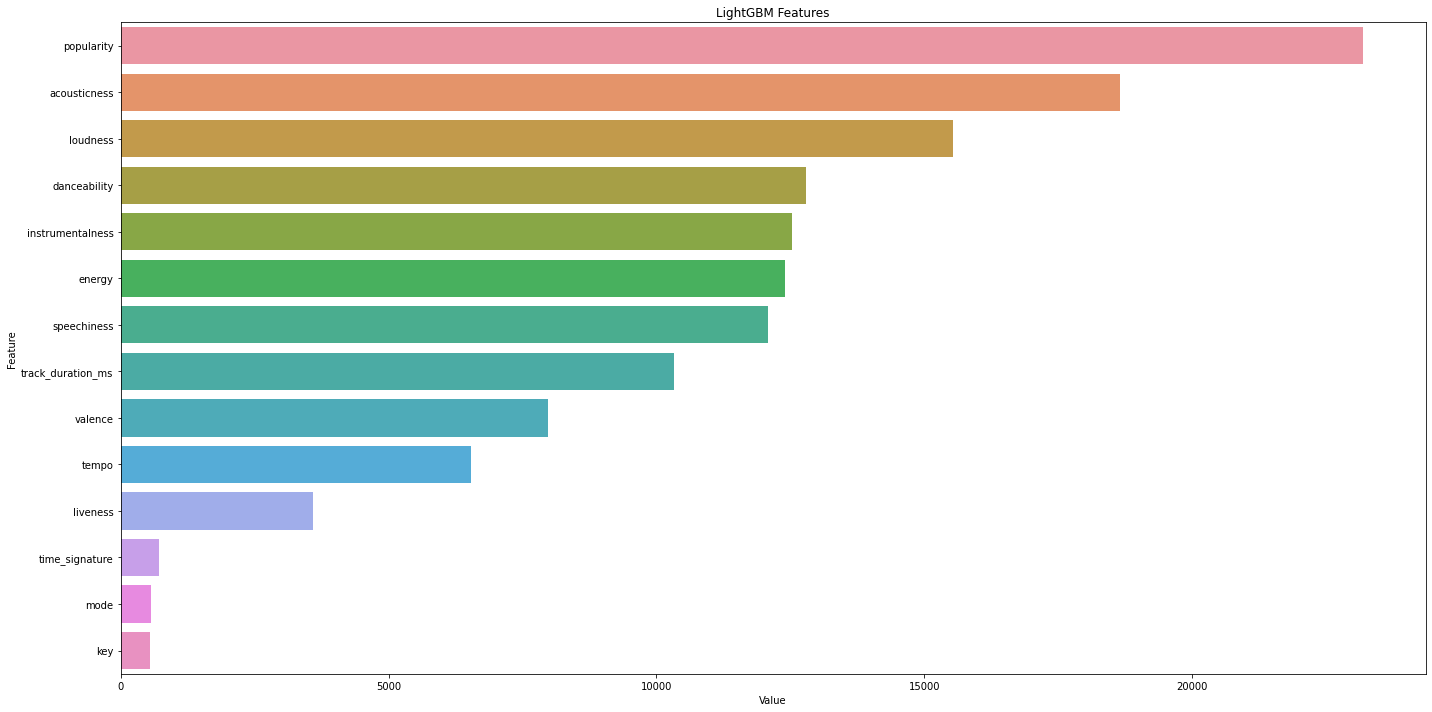

In [44]:
# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

#### sử dụng ExtraTreesClassifier

In [45]:
model = ExtraTreesClassifier()
model.fit(X,y)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

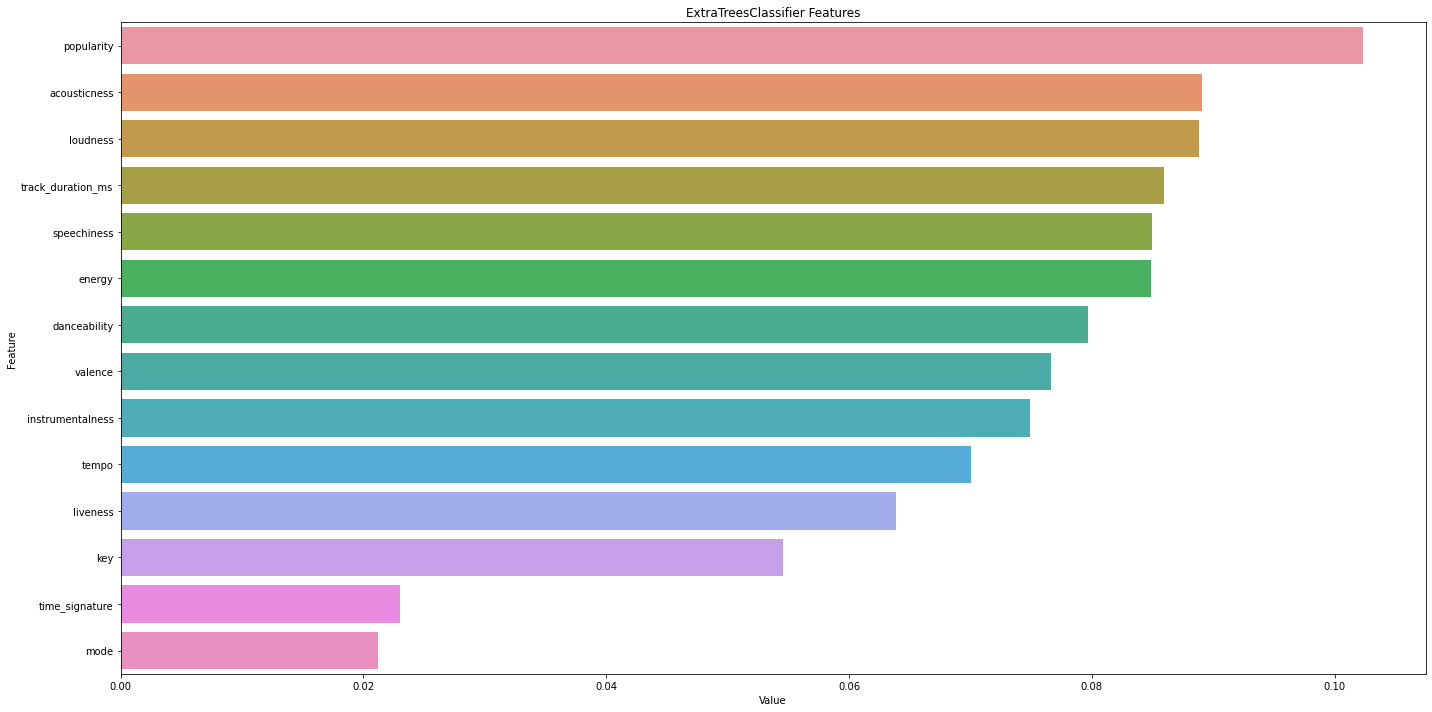

In [46]:
# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('ExtraTreesClassifier Features')
plt.tight_layout()
plt.show()

### Xác định các features quan trọng

Dựa vào biểu đồ nhóm em chọn ra 5 features tốt nhất từ 2 model hình trên là: `loudness`, `danceability`, `acousticness`, `popularity`, `track_duration_ms`

In [59]:
features = ['loudness', 'danceability', 'acousticness', 'popularity', 'track_duration_ms']

### Tạo các test-cases

In [60]:
fraction = 3
track_id_all = generate_playlists(pd_tracks, pd_playlists)
track_id_test = generate_testcases(track_id_all, fraction = fraction)

In [61]:
all_playlistID_for_tests = list(track_id_test.keys())

In [62]:
pd_full_tests = pd_full.copy()
pd_full_tests = pd_full_tests[pd_full_tests['playlist_id'].isin(all_playlistID_for_tests)]

### Modeling

In [63]:
def multi_feats_baseline(tracks, df, n_pred, feats):
    recs_id = []
    for t in tracks:
      sum_feat_values = 0
      for feat in feats:
        feat_values = df[df['track_id'] == t][feat]
        sum_feat_values = sum_feat_values + np.abs(df[feat] - feat_values.values[0]) ** 2
      
      df['rec_df_feats'] = sum_feat_values ** (1 / 2)
      one_recs_id = list(df.sort_values(by=['rec_df_feats'])['track_id'][1:].values)
      recs_id.extend([track for track in one_recs_id if track not in tracks][0:n_pred])

    preds = collections.Counter(recs_id).most_common(n_pred)
    pred_titles = [p[0] for p in preds]

    tracks_name = []
    for id_track in pred_titles:
      tracks_name.extend(list(np.unique(df[df['track_id'] == id_track]['track_name'].values)))

    return pred_titles, tracks_name

### Testing

**Bây giờ ta sẽ thử test phương pháp này trên playlist đầu tiên của tập test**

In [64]:
playlists_to_test = all_playlistID_for_tests[0]

In [65]:
all_name_songs = list(pd_full[pd_full['track_id'].isin(track_id_all[playlists_to_test])]['track_name'].values)
given_songs_name = list(pd_full[pd_full['track_id'].isin(track_id_test[playlists_to_test])]['track_name'].values)

In [66]:
track_id_result, track_name_result = multi_feats_baseline(track_id_test[playlists_to_test], pd_full_tests, len(track_id_all[playlists_to_test])-len(track_id_test[playlists_to_test]), features)

In [67]:
print('Songs given: ', given_songs_name, '\n')
print('Songs recommended: ', track_name_result, '\n')

Songs given:  ['The First Big Peel Thing - Peel Session', 'Back to the Old House - John Peel Session 14/09/83', 'Sheela-Na-Gig - Peel 29.10.91', 'Little Rhymes - John Peel Session 15/11/2001', 'Hip Priest - Peel Session 31/3/81', 'Two Sevens Clash - John Peel Session', 'When Saturday Comes (John Peel Session 16/11/1980) - Eden Studio Sessions for John Peel 16/11/1980', 'Fade Away - John Peel 5/11/91', 'Happy Cycling', 'Bombers - In Concert - John Peel, Recorded 3.6.71, 2000 Remaster', 'The Classical (Peel session) - BBC Radio One John Peel Live Session', 'Like Rats', 'Raindrops - BBC In Session - John Peel 27/04/93', 'Popscene - Live At Peel Acres', 'Maniac - Peel Session', 'Love And Romance - John Peel BBC Radio 1 Session 1977', 'You Sexy Thing - 16/6/87 BBC Radio 1 John Peel Session', "Everybody's Got Something To Hide (Except Me And My Monkey) - John Peel BBC Sessions", 'Back Side Of The Moon - John Peel Session', 'Whiskey In The Jar - BBC Radio 1 John Peel Session'] 

Songs recomme

**Bây giờ ta sẽ sử dụng tất cả 100 playlists trong bộ test để đánh giá**

In [68]:
def test_multi_feats(pd_playlists, pd_full, features, fraction = 5, nums_playlists_test = 100):
  r_score = []

  track_id_all = generate_playlists(pd_full, pd_playlists, nums_playlists_to_test = nums_playlists_test)
  track_id_test = generate_testcases(track_id_all, fraction = fraction)

  all_playlistID_for_tests = list(track_id_test.keys())

  pd_full_tests = pd_full.copy()
  pd_full_tests = pd_full_tests[pd_full_tests['playlist_id'].isin(all_playlistID_for_tests)]
  pd_full_tests = pd_full_tests.reset_index(drop = True)

  for each_playlist in all_playlistID_for_tests:
    track_id_result, track_name_result = multi_feats_baseline(track_id_test[each_playlist], pd_full_tests, len(track_id_all[each_playlist])-len(track_id_test[each_playlist]), features)
    
    all_name_songs = list(pd_full_tests[pd_full_tests['track_id'].isin(track_id_all[each_playlist])]['track_name'].values)
    given_songs_name = list(pd_full_tests[pd_full_tests['track_id'].isin(track_id_test[each_playlist])]['track_name'].values) 
    test_songs_name = [x for x in all_name_songs if x not in given_songs_name]

    r_score.append(r_precision(track_name_result, test_songs_name))

  return r_score

In [69]:
r_score = test_multi_feats(pd_playlists, pd_full, features, fraction = 5, nums_playlists_test = 100)

print("Average R precision: " + str(np.mean(r_score)))
print("Max R precision: " + str(np.max(r_score)))

Average R precision: 0.03910272869047924
Max R precision: 0.3875


**Test model trên những fraction khác nhau**:

Fraction là tỷ lệ bài hát hiện có trong mỗi playlist, ta dựa vào chúng để đề xuất các bài hát còn lại, ví dụ playlist có 100 bài hát, ta dùng 1/5 số đó (20 bài hát) để dựa vào đó đề xuất 80 bài hát còn lại.

Fraction có giá trị càng bé hoặc càng lớn thì tỷ lệ đề xuất trúng càng thấp.

Ở đây ta test model với các fraction lần lượt là 2 - 10, tức là trong một playlist có 100 bài hát thì ta sẽ dùng 50, 100/3, 25, ..., 10 bài hát đầu tiên để đề xuất số bài hát còn lại.

In [70]:
fraction_to_test = list(np.arange(2, 11))

result_mean = {}
result_max = {}

for fraction in fraction_to_test:
  r_score = test_multi_feats(pd_playlists, pd_full, features, fraction = fraction, nums_playlists_test = 100)
  result_mean[fraction] = np.mean(r_score)
  result_max[fraction] = np.max(r_score)
  print('-'*30)
  print(f'fraction {fraction}:')
  print("Average R precision: " + str(np.mean(r_score)))
  print("Max R precision: " + str(np.max(r_score))) 
  print('-'*30)

------------------------------
fraction 2:
Average R precision: 0.03307300845838395
Max R precision: 0.36363636363636365
------------------------------
------------------------------
fraction 3:
Average R precision: 0.02434445388177483
Max R precision: 0.2835820895522388
------------------------------
------------------------------
fraction 4:
Average R precision: 0.043052295120086924
Max R precision: 0.34782608695652173
------------------------------
------------------------------
fraction 5:
Average R precision: 0.06125892743399074
Max R precision: 0.6625
------------------------------
------------------------------
fraction 6:
Average R precision: 0.03536717583233854
Max R precision: 0.2261904761904762
------------------------------
------------------------------
fraction 7:
Average R precision: 0.05199143118119165
Max R precision: 0.37209302325581395
------------------------------
------------------------------
fraction 8:
Average R precision: 0.036240820686241605
Max R precision: 

In [72]:
print(f'Mean Average R precision over all fractions: {np.mean(list(result_mean.values()))}')
print(f'Mean Max R precision over all fractions: {np.mean(list(result_max.values()))}')

Mean Average R precision over all fractions: 0.03941372808493854
Mean Max R precision over all fractions: 0.3810007201323231


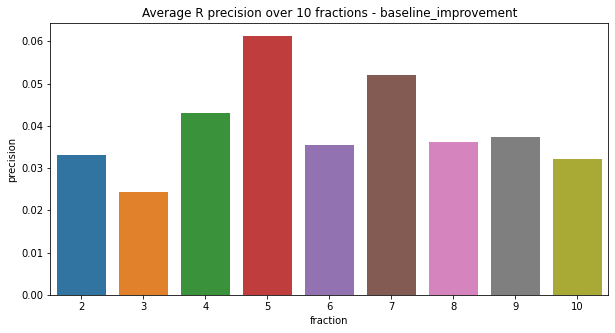

In [73]:
plt.figure(figsize=(10, 5))

ax = sns.barplot(x=list(result_mean.keys()), y=list(result_mean.values()))

_ = ax.set_title('Average R precision over 10 fractions - baseline_improvement')

ax.set_ylabel('precision')
ax.set_xlabel('fraction')

plt.savefig('../../images/baseline_improvement_average_R_precision.png', bbox_inches = 'tight')

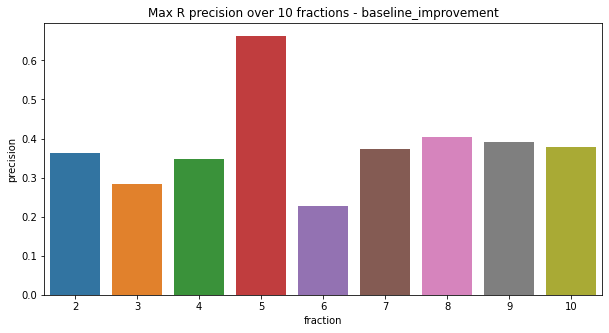

In [74]:
plt.figure(figsize=(10, 5))

ax = sns.barplot(x=list(result_max.keys()), y=list(result_max.values()))

_ = ax.set_title('Max R precision over 10 fractions - baseline_improvement')

ax.set_ylabel('precision')
ax.set_xlabel('fraction')

plt.savefig('../../images/baseline_improvement_max_R_precision.png', bbox_inches = 'tight')

In [75]:
result = []

for keys in result_mean:
  result.append({'mean' : result_mean[keys]})

i = 0
for keys in result_max:
  result[i]['max'] = result_max[keys]
  result[i]['fraction'] = i + 2
  i = i + 1

result

[{'fraction': 2, 'max': 0.36363636363636365, 'mean': 0.03307300845838395},
 {'fraction': 3, 'max': 0.2835820895522388, 'mean': 0.02434445388177483},
 {'fraction': 4, 'max': 0.34782608695652173, 'mean': 0.043052295120086924},
 {'fraction': 5, 'max': 0.6625, 'mean': 0.06125892743399074},
 {'fraction': 6, 'max': 0.2261904761904762, 'mean': 0.03536717583233854},
 {'fraction': 7, 'max': 0.37209302325581395, 'mean': 0.05199143118119165},
 {'fraction': 8, 'max': 0.40350877192982454, 'mean': 0.036240820686241605},
 {'fraction': 9, 'max': 0.3918918918918919, 'mean': 0.03730313905403369},
 {'fraction': 10, 'max': 0.37777777777777777, 'mean': 0.03209230111640491}]

In [76]:
df_result = pd.DataFrame(result)
df_result.to_csv('baseline_improvement_result.csv', index = False)

**Nhận xét**: 

về cơ bản model này không khác gì baseline với multi features, ở đây nhóm chỉ nghĩ ra cách chọn features dựa trên feature importance từ bài toán classification thay vì sử dụng kết quả phân bố từ EDA như baseline. Kết quả **Average R precision** đạt được cũng không cao lắm, chỉ tầm 0.03 - 0.06 (tức là đoán đúng được 3 - 6% các playlist) qua các fraction từ 2-10. 